In [1]:
# Librerías estándar y de terceros
import os
import sys
import gc
import math as m
import numpy as np
import scipy
import pandas as pd
from scipy import *
from scipy.signal import butter, filtfilt, hilbert
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
from scipy.interpolate import interp1d

import pylab
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
         'axes.labelsize': 33,
         'axes.titlesize':33,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
    'font.family': 'STIXGeneral',  
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True, 
}

pylab.rcParams.update(params)
sys.path.append('/projects/DEIKE/cmartinb/functions')
from prepare import load_object, save_object, field
from defs import Case, Interface2D
from phase import extract_phase
from funciones import * 

os.chdir('/projects/DEIKE/cmartinb/')

In [2]:
#Common parameters 
kp = 4
u = 0.5
lambdap = 2*m.pi/kp

L0 = 2*np.pi;

/projects/DEIKE/cmartinb/betas/betas_re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10.csv
/projects/DEIKE/cmartinb/betas/betas_re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10.csv
/projects/DEIKE/cmartinb/betas/betas_re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10.csv
/projects/DEIKE/cmartinb/betas/betas_re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10.csv


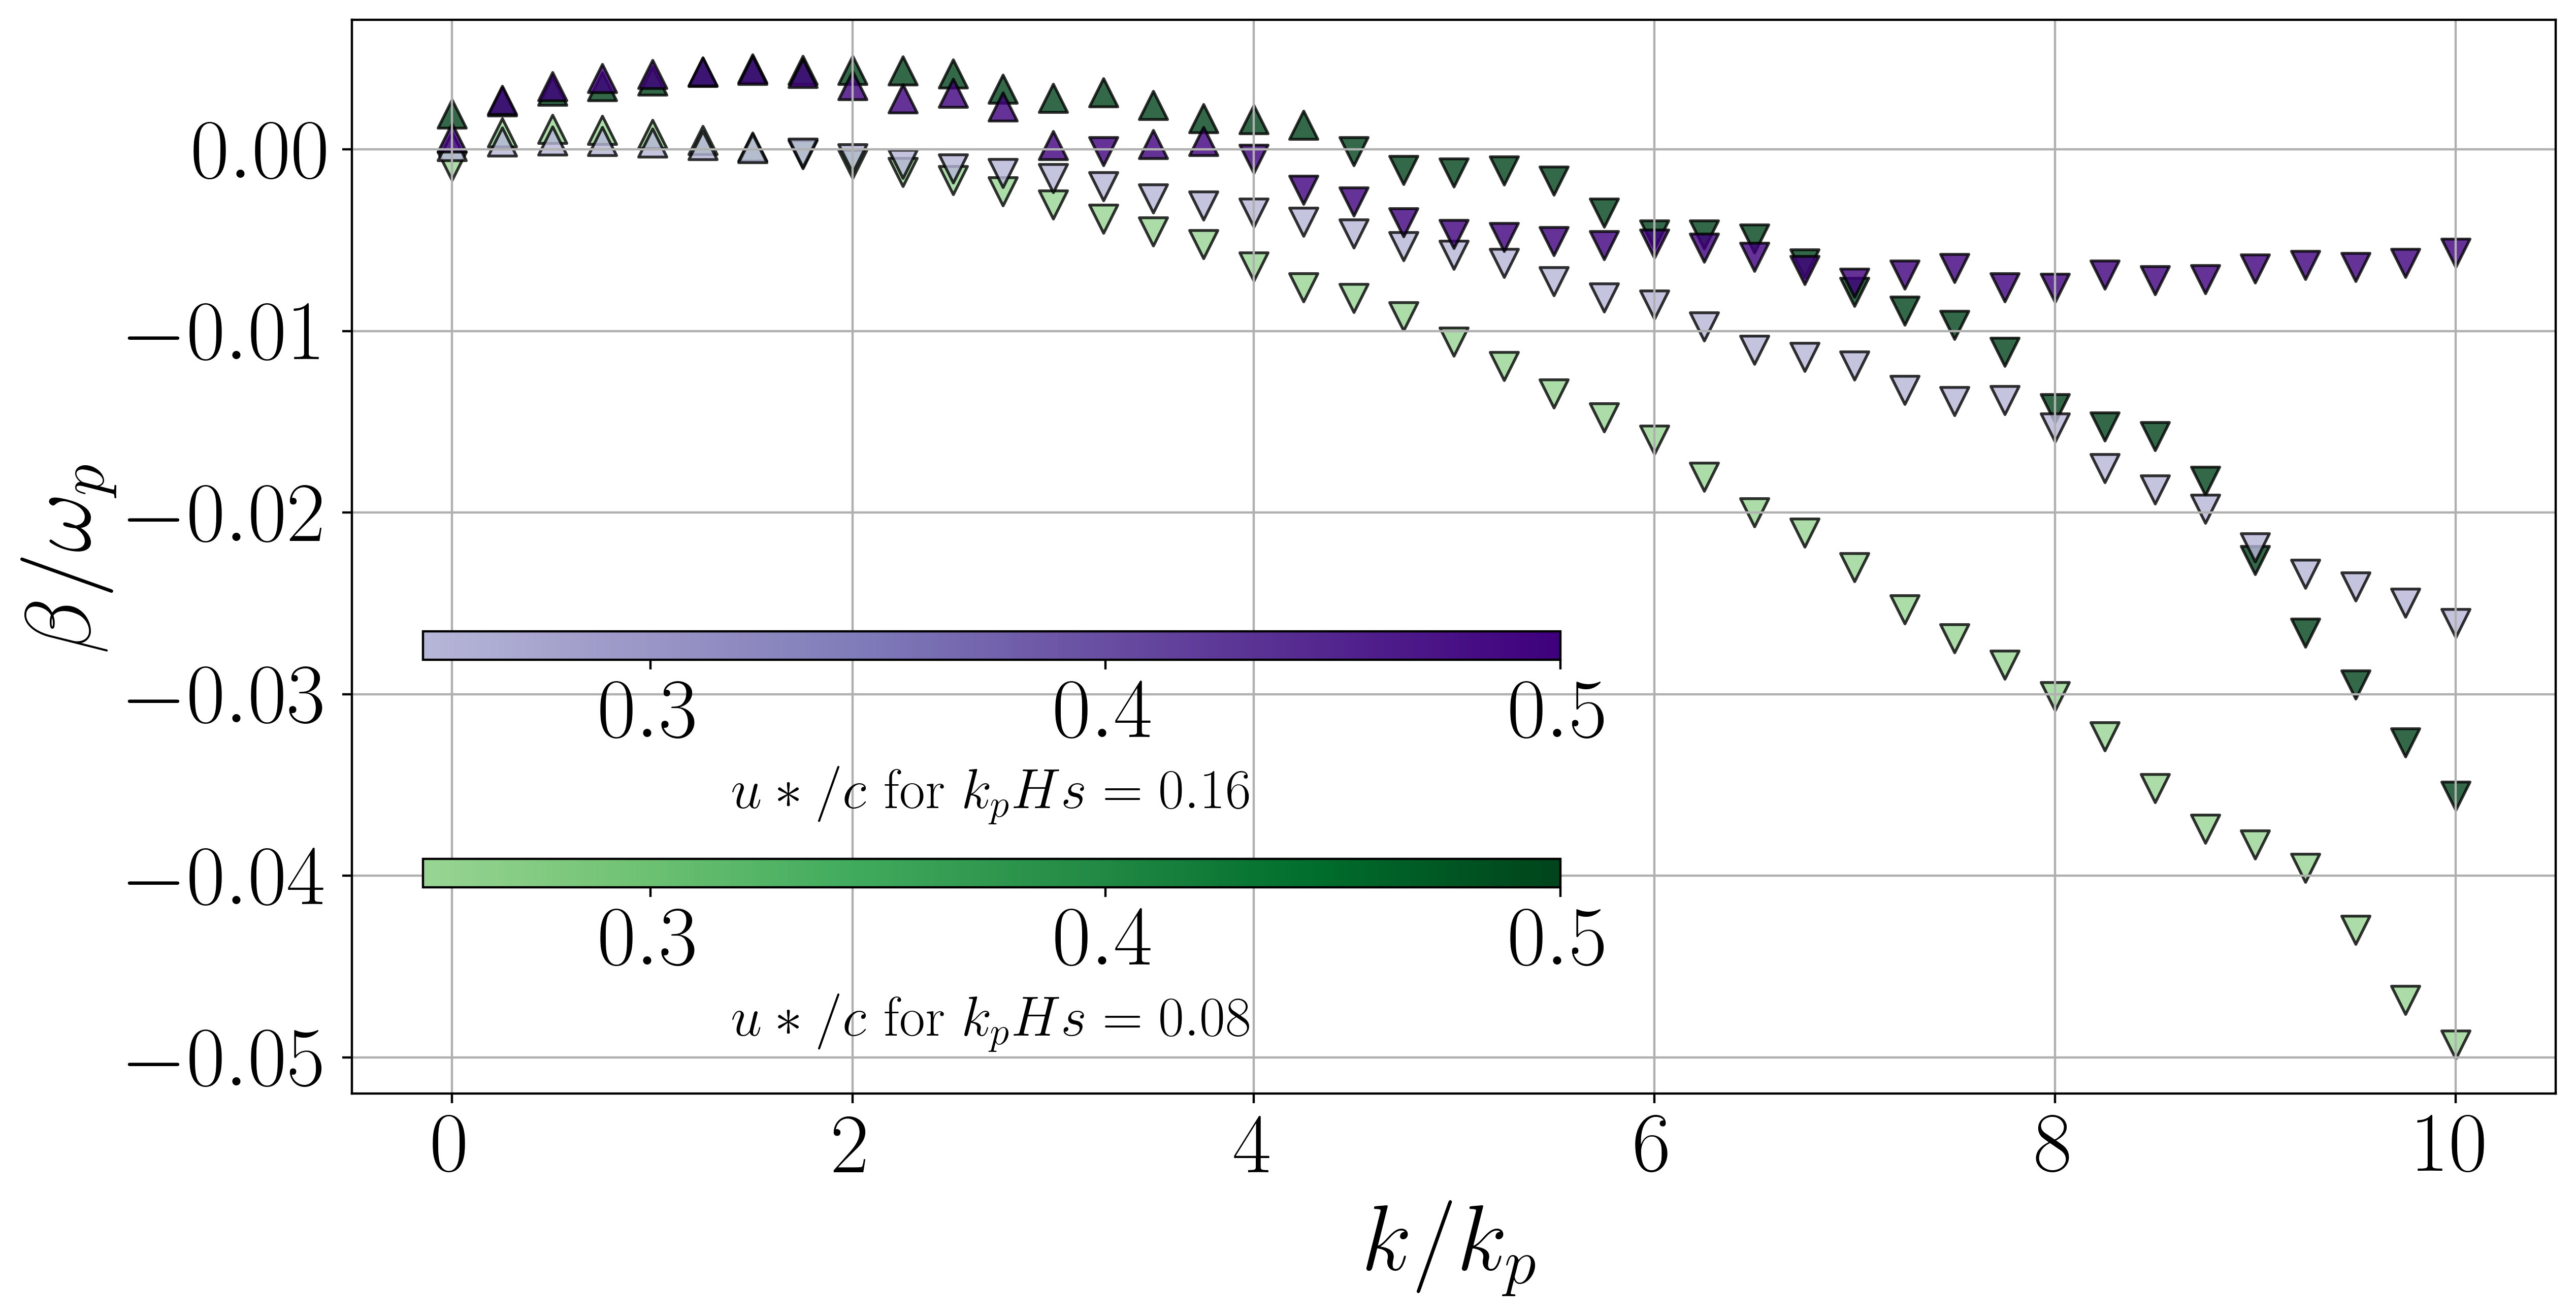

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
import pylab
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm

# List of cases
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize':33,
          'xtick.labelsize':30,
          'ytick.labelsize':30,
          'font.family': 'STIXGeneral',  
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True, 
}

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Function to extract Re value from the case name
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '').replace('e', r'\times 10^')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Existing function to calculate parameters
def calculate_parameters(kpHs, uoc, u, kp):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")
    
    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10**4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Create custom colormaps avoiding the lightest shades and darkening them more
cmap_08 = LinearSegmentedColormap.from_list("greens_darker", cm.Greens(np.linspace(0.4, 1, 100)))
cmap_16 = LinearSegmentedColormap.from_list("purples_darker", cm.Purples(np.linspace(0.4, 1, 100)))
norm = Normalize(vmin=0.25, vmax=0.50)

# Loop through each case
for idx, case in enumerate(cases):
    # Read the data
    print(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')

    # Define growth and decay
    df_growth = df_beta[df_beta['Tipo'] == 'Growth']
    df_decay = df_beta[df_beta['Tipo'] == 'Decay']

    k_growth = df_growth['k']
    k_decay = df_decay['k']
    beta_growth = df_growth['Beta']
    beta_decay = df_decay['Beta']

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)

    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)

    # Choose the colormap based on ak value
    if kpHs == '0.08':
        color = cmap_08(norm(uoc_val))
    elif kpHs == '0.16':
        color = cmap_16(norm(uoc_val))
    else:
        color = 'gray'  # default color if not recognized

    # Plotting with an outline
    plt.scatter([k/4 for k in k_growth], [beta/omegap for beta in beta_growth], color=color, marker= "^", alpha=0.8, edgecolors='black', linewidth=1, s=100)
    plt.scatter([k/4 for k in k_decay], [beta/omegap for beta in beta_decay], color=color, marker= "v", alpha=0.8, edgecolors='black', linewidth=1, s=100)

# Add labels and title
plt.xlabel(r'$k/k_p$')
plt.ylabel(r'$\beta / \omega_{p}$')

# Add grid for better visualization
plt.grid(True)

# Define colorbar positions slightly higher and shorter
colorbar_positions = {
    '0.08': [0.15, 0.27, 0.4, 0.02],
    '0.16': [0.15, 0.43, 0.4, 0.02]
}
# Create and place colorbars inside the plot
sm_08 = plt.cm.ScalarMappable(cmap=cmap_08, norm=norm)
sm_08.set_array([])  # Necessary for the colorbar to function
cb_ax_08 = fig.add_axes(colorbar_positions['0.08'])
cb_08 = plt.colorbar(sm_08, cax=cb_ax_08, orientation='horizontal')
cb_08.set_label(r'$u*/c$ for $k_pHs = 0.08$', size=20)

sm_16 = plt.cm.ScalarMappable(cmap=cmap_16, norm=norm)
sm_16.set_array([])  # Necessary for the colorbar to function
cb_ax_16 = fig.add_axes(colorbar_positions['0.16'])
cb_16 = plt.colorbar(sm_16, cax=cb_ax_16, orientation='horizontal')
cb_16.set_label(r'$u*/c$ for $k_pHs = 0.16$', size=20)

# Adjust limits if necessary
#plt.yscale('log')
#plt.xlim([-0.2, 7])
#plt.ylim([-0.008, 0.008])

# Save the plot
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/betaomegap_kkp_Rea{reA}_Bo{Bo}_L{maxLevel}_colorbars.png')
# Show the plot
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
import pylab
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm

# List of cases
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize':33,
          'xtick.labelsize':30,
          'ytick.labelsize':30,
          'font.family': 'STIXGeneral',  
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True, 
}

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Function to extract Re value from the case name
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '').replace('e', r'\times 10^')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Existing function to calculate parameters
def calculate_parameters(kpHs, uoc, u, kp):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")
    
    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10**4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Create custom colormaps avoiding the lightest shades and darkening them more
cmap_08 = LinearSegmentedColormap.from_list("greens_darker", cm.Greens(np.linspace(0.4, 1, 100)))
cmap_16 = LinearSegmentedColormap.from_list("purples_darker", cm.Purples(np.linspace(0.4, 1, 100)))
norm = Normalize(vmin=0.25, vmax=0.50)

# Loop through each case
for idx, case in enumerate(cases):
    # Read the data
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')


    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values
    

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)
    u = 0.5 
    kp = 4 
    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)
    # u* is defined as 0.5
    u_star = 0.5
    
    # Verificar si la columna 'Omega' está presente
    if 'Omega' in df_combined.columns:
        omega = df_combined['Omega'].values
        
        #print('k:', k_combined)
        #print('omega:', omega)
    else:
        print(f"Error: La columna 'Omega' no está presente en el archivo {case}")
        continue
    
    # Calculate u*/c(k)
    u_star_over_c = [u_star / (omega_i / k_i) if k_i != 0 else np.nan for k_i, omega_i in zip(k_combined, omega)]
   
    
    # Choose the colormap based on ak value
    if kpHs == '0.08':
        color = cmap_08(norm(uoc_val))
    elif kpHs == '0.16':
        color = cmap_16(norm(uoc_val))
    else:
        color = 'gray'  # default color if not recognized

        
    u_star_over_c_clean = [u for u in u_star_over_c if not np.isnan(u)]
    beta_clean = [beta for u, beta in zip(u_star_over_c, beta_combined) if not np.isnan(u)]
    
    # Plotting with an outline
    plt.scatter(u_star_over_c_clean, beta_clean, color=color, marker= "^", alpha=0.8, edgecolors='black', linewidth=1, s=100)
    #print(beta_clean)
    #print(u_star_over_c_clean)

# Agregar etiquetas y título
plt.yscale('log')
plt.xscale('log')
plt.ylim([10**(-6), 10**0])
plt.xlabel(r'$u^*/c(k)$')
plt.ylabel(r'$\beta$')


# Plant's estimation
# β = (0.04 ± 0.02)(u∗/c)2
UC = 10**(np.linspace(-1,1,100))
plt.plot(UC, 0.06*UC**2, '--', lw=1, c='gray', alpha=0.5)
plt.plot(UC, 0.02*UC**2, '--', lw=1, c='gray', alpha=0.5)

# Add grid for better visualization
plt.grid(True)

# Define colorbar positions slightly higher and shorter
colorbar_positions = {
    '0.08': [0.58, 0.23, 0.3, 0.02],
    '0.16': [0.58, 0.38, 0.3, 0.02]
}
# Create and place colorbars inside the plot
sm_08 = plt.cm.ScalarMappable(cmap=cmap_08, norm=norm)
sm_08.set_array([])  # Necessary for the colorbar to function
cb_ax_08 = fig.add_axes(colorbar_positions['0.08'])
cb_08 = plt.colorbar(sm_08, cax=cb_ax_08, orientation='horizontal')
cb_08.set_label(r'$u*/c$ for $k_pHs = 0.08$', size=20)
cb_08.ax.tick_params(labelsize=20) 

sm_16 = plt.cm.ScalarMappable(cmap=cmap_16, norm=norm)
sm_16.set_array([])  # Necessary for the colorbar to function
cb_ax_16 = fig.add_axes(colorbar_positions['0.16'])
cb_16 = plt.colorbar(sm_16, cax=cb_ax_16, orientation='horizontal')
cb_16.set_label(r'$u*/c$ for $k_pHs = 0.16$', size=20)
cb_16.ax.tick_params(labelsize=20) 

# Adjust limits if necessary
#plt.yscale('log')
#plt.xlim([-0.2, 7])
#plt.ylim([-0.008, 0.008])

# Save the plot
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/betaomegap_kkp_Rea{reA}_Bo{Bo}_L{maxLevel}_colorbars.png')
# Show the plot
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
import pylab
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm

# List of cases
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize':33,
          'xtick.labelsize':30,
          'ytick.labelsize':30,
          'font.family': 'STIXGeneral',  
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True, 
}

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Function to extract Re value from the case name
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '').replace('e', r'\times 10^')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Existing function to calculate parameters
def calculate_parameters(kpHs, uoc, u, kp):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")
    
    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10**4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Create custom colormaps avoiding the lightest shades and darkening them more
cmap_08 = LinearSegmentedColormap.from_list("greens_darker", cm.Greens(np.linspace(0.4, 1, 100)))
cmap_16 = LinearSegmentedColormap.from_list("purples_darker", cm.Purples(np.linspace(0.4, 1, 100)))
norm = Normalize(vmin=0.25, vmax=0.50)

# Loop through each case
for idx, case in enumerate(cases):
    # Read the data
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')


    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values
    

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)
    u = 0.5 
    kp = 4 
    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)
    # u* is defined as 0.5
    u_star = 0.5
    
    # Verificar si la columna 'Omega' está presente
    if 'Omega' in df_combined.columns:
        omega = df_combined['Omega'].values
        
        #print('k:', k_combined)
        #print('omega:', omega)
    else:
        print(f"Error: La columna 'Omega' no está presente en el archivo {case}")
        continue
    
    # Calculate u*/c(k)
    #u_star_over_c = [u_star / (omega_i / k_i) if k_i != 0 else np.nan for k_i, omega_i in zip(k_combined, omega)]
   
    c_k = [(omega_i / k_i) if k_i != 0 else np.nan for k_i, omega_i in zip(k_combined, omega)]
    
    # Choose the colormap based on ak value
    if kpHs == '0.08':
        color = cmap_08(norm(uoc_val))
    elif kpHs == '0.16':
        color = cmap_16(norm(uoc_val))
    else:
        color = 'gray'  # default color if not recognized

    c_norm = [(omega_i / k_i)*(uoc_val/0.5) if k_i != 0 else np.nan for k_i, omega_i in zip(k_combined, omega)]
        
    u_star_over_c_clean = [u for u in u_star_over_c if not np.isnan(u)]
    beta_clean = [beta for u, beta in zip(u_star_over_c, beta_combined) if not np.isnan(u)]
    
    # Plotting with an outline
    #plt.scatter(u_star_over_c_clean, beta_clean, color=color, marker= "^", alpha=0.8, edgecolors='black', linewidth=1, s=100)
    plt.scatter(k_combined/4, c_norm, color=color, marker= "^", alpha=0.8, edgecolors='black', linewidth=1, s=100)
    
    #print(beta_clean)
    #print(u_star_over_c_clean)

# Agregar etiquetas y título
#plt.yscale('log')
#plt.xscale('log')
plt.ylim([10**(-6), 10**0])
plt.xlabel(r'$k/k_p$')
plt.ylabel(r'$c(k)/c_p(t=0)$')


# Plant's estimation
# β = (0.04 ± 0.02)(u∗/c)2
k_kp =(np.linspace(0,10,100))
#plt.plot(k_kp[20:-1], (0.5)**k_kp[20:-1] + 0.2 , '--', lw=1, c='gray', alpha=0.5)
#plt.plot(k_kp[0:15], (0.5)**k_kp[0:15], '--', lw=1, c='gray', alpha=0.5)
#plt.plot(k_kp, 0.02*UC**2, '--', lw=1, c='gray', alpha=0.5)


# Add grid for better visualization
plt.grid(True)

# Define colorbar positions slightly higher and shorter
colorbar_positions = {
    '0.08': [0.58, 0.67, 0.3, 0.02],
    '0.16': [0.58, 0.83, 0.3, 0.02]
}
# Create and place colorbars inside the plot
sm_08 = plt.cm.ScalarMappable(cmap=cmap_08, norm=norm)
sm_08.set_array([])  # Necessary for the colorbar to function
cb_ax_08 = fig.add_axes(colorbar_positions['0.08'])
cb_08 = plt.colorbar(sm_08, cax=cb_ax_08, orientation='horizontal')
cb_08.set_label(r'$u*/c$ for $k_pHs = 0.08$', size=20)
cb_08.ax.tick_params(labelsize=20) 

sm_16 = plt.cm.ScalarMappable(cmap=cmap_16, norm=norm)
sm_16.set_array([])  # Necessary for the colorbar to function
cb_ax_16 = fig.add_axes(colorbar_positions['0.16'])
cb_16 = plt.colorbar(sm_16, cax=cb_ax_16, orientation='horizontal')
cb_16.set_label(r'$u*/c$ for $k_pHs = 0.16$', size=20)
cb_16.ax.tick_params(labelsize=20) 

# Adjust limits if necessary
#plt.yscale('log')
#plt.xlim([-0.2, 7])
#plt.ylim([-0.008, 0.008])

# Save the plot
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/betaomegap_kkp_Rea{reA}_Bo{Bo}_L{maxLevel}_colorbars.png')
# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
import pylab
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm
from scipy.optimize import curve_fit

# List of cases
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize':33,
          'xtick.labelsize':30,
          'ytick.labelsize':30,
          'font.family': 'STIXGeneral',  
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True, 
}

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Function to extract Re value from the case name
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '').replace('e', r'\times 10^')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Existing function to calculate parameters
def calculate_parameters(kpHs, uoc, u, kp):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")
    
    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10**4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

# Define the exponential decay function for fitting
def exp_decay(k, A, alpha):
    return A * np.exp(-alpha * k)

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Create custom colormaps avoiding the lightest shades and darkening them more
cmap_08 = LinearSegmentedColormap.from_list("greens_darker", cm.Greens(np.linspace(0.4, 1, 100)))
cmap_16 = LinearSegmentedColormap.from_list("purples_darker", cm.Purples(np.linspace(0.4, 1, 100)))
norm = Normalize(vmin=0.25, vmax=0.50)

# Loop through each case
for idx, case in enumerate(cases):
    # Read the data
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values
    
    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)
    u = 0.5 
    kp = 4 
    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)
    u_star = 0.5
    
    # Verificar si la columna 'Omega' está presente
    if 'Omega' in df_combined.columns:
        omega = df_combined['Omega'].values
    else:
        print(f"Error: La columna 'Omega' no está presente en el archivo {case}")
        continue
    
    c_norm = [(omega_i / k_i)*(uoc_val/0.5) if k_i != 0 else np.nan for k_i, omega_i in zip(k_combined, omega)]
    
    # Eliminate NaN and infinite values
    k_normalized = k_combined / kp
    k_normalized_clean = []
    c_norm_clean = []
    
    for k_val, c_val in zip(k_normalized, c_norm):
        if np.isfinite(k_val) and np.isfinite(c_val):
            k_normalized_clean.append(k_val)
            c_norm_clean.append(c_val)
    
    k_normalized_clean = np.array(k_normalized_clean)
    c_norm_clean = np.array(c_norm_clean)
    
    # Fit the curve using scipy's curve_fit
    popt, pcov = curve_fit(exp_decay, k_normalized_clean, c_norm_clean, p0=(1, 1))
    
    # Print the fitting constants
    A_fit, alpha_fit = popt
    print(f"$Case: {case}$ $- A: {A_fit}$, $alpha: {alpha_fit}$")

    # Plotting the data points
    plt.scatter(k_normalized_clean, c_norm_clean, color=color, marker= "^", alpha=0.8, edgecolors='black', linewidth=1, s=100)
    
    # Plotting the fitted curve
    k_fit = np.linspace(0, max(k_normalized_clean), 100)
    c_fit = exp_decay(k_fit, *popt)
    plt.plot(k_fit, c_fit, color=color, linewidth=2)

# Agregar etiquetas y título
plt.ylim([0, 1])
plt.xlabel(r'$k/k_p$')
plt.ylabel(r'$c(k)/c_p(t=0)$')

# Add grid for better visualization
plt.grid(True)
plt.legend()

# Show the plot
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
import pylab
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm

# List of cases
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize':33,
          'xtick.labelsize':30,
          'ytick.labelsize':30,
          'font.family': 'STIXGeneral',  
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True, 
}

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Function to extract Re value from the case name
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '').replace('e', r'\times 10^')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Existing function to calculate parameters
def calculate_parameters(kpHs, uoc, u, kp):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")
    
    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10**4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Create custom colormaps avoiding the lightest shades and darkening them more
cmap_08 = LinearSegmentedColormap.from_list("greens_darker", cm.Greens(np.linspace(0.4, 1, 100)))
cmap_16 = LinearSegmentedColormap.from_list("purples_darker", cm.Purples(np.linspace(0.4, 1, 100)))
norm = Normalize(vmin=0.25, vmax=0.50)

# Loop through each case
for idx, case in enumerate(cases):
    # Read the data
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values
    
    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)
    u = 0.5 
    kp = 4 
    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)
    # u* is defined as 0.5
    u_star = 0.5
    
    # Verificar si la columna 'Omega' está presente
    if 'Omega' in df_combined.columns:
        omega = df_combined['Omega'].values
    else:
        print(f"Error: La columna 'Omega' no está presente en el archivo {case}")
        continue
    
    # Calculate u*/c(k)
    u_star_over_c = [u_star / (omega_i / k_i) if k_i != 0 else np.nan for k_i, omega_i in zip(k_combined, omega)]
   
    # Choose the colormap based on ak value
    if kpHs == '0.08':
        color = cmap_08(norm(uoc_val))
    elif kpHs == '0.16':
        color = cmap_16(norm(uoc_val))
    else:
        color = 'gray'  # default color if not recognized

    u_star_over_c_clean = [u for u in u_star_over_c if not np.isnan(u)]
    beta_clean = [beta for u, beta in zip(u_star_over_c, beta_combined) if not np.isnan(u)]
    
    # Plotting with an outline
    scatter = ax.scatter(u_star_over_c_clean, beta_clean, color=color, marker= "^", alpha=0.8, edgecolors='black', linewidth=1, s=100)

    # Highlight the k = 1 point for each case with a red circle
    for i, k_val in enumerate(k_combined):
        if k_val == 4:
            ax.plot(u_star_over_c[i], beta_combined[i], 'o', markerfacecolor='none', markeredgecolor='red', markersize=12, markeredgewidth=2)

# Agregar etiquetas y título
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim([10**(-6), 10**0])
plt.xlabel(r'$u^*/c(k)$')
plt.ylabel(r'$\beta$')

# Plant's estimation
# β = (0.04 ± 0.02)(u∗/c)2
#UC = 10**(np.linspace(-1,1,10))
#plt.plot(UC, 0.06*UC**2, '--', lw=1, c='gray', alpha=0.5)
#plt.plot(UC, 0.02*UC**2, '--', lw=1, c='gray', alpha=0.5)

# Add grid for better visualization
plt.grid(True)

# Define colorbar positions slightly higher and shorter
colorbar_positions = {
    '0.08': [0.58, 0.23, 0.3, 0.02],
    '0.16': [0.58, 0.38, 0.3, 0.02]
}
# Create and place colorbars inside the plot
sm_08 = plt.cm.ScalarMappable(cmap=cmap_08, norm=norm)
sm_08.set_array([])  # Necessary for the colorbar to function
cb_ax_08 = fig.add_axes(colorbar_positions['0.08'])
cb_08 = plt.colorbar(sm_08, cax=cb_ax_08, orientation='horizontal')
cb_08.set_label(r'$u*/c$ for $k_pHs = 0.08$', size=20)
cb_08.ax.tick_params(labelsize=20) 

sm_16 = plt.cm.ScalarMappable(cmap=cmap_16, norm=norm)
sm_16.set_array([])  # Necessary for the colorbar to function
cb_ax_16 = fig.add_axes(colorbar_positions['0.16'])
cb_16 = plt.colorbar(sm_16, cax=cb_ax_16, orientation='horizontal')
cb_16.set_label(r'$u*/c$ for $k_pHs = 0.16$', size=20)
cb_16.ax.tick_params(labelsize=20) 

# Save the plot
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/betaomegap_kkp_Rea{reA}_Bo{Bo}_L{maxLevel}_colorbars.png')
# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab

# Parámetros de configuración para los gráficos
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize': 33,
          'xtick.labelsize': 30,
          'ytick.labelsize': 30,
          'font.family': 'STIXGeneral',
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True,
          }

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Función para extraer parámetros del nombre del caso
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Inicializar el gráfico
fig, ax = plt.subplots(figsize=(14, 7))

# Definir mapa de colores
colors = plt.cm.get_cmap('tab10', len(cases))

# Lista para almacenar puntos de cruce
crossing_points = []

# Loop a través de cada caso
for idx, case in enumerate(cases):
    # Leer los datos
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')
    
    # Imprimir las columnas del DataFrame para verificar la presencia de 'Omega'
    #print(f"Columnas del archivo {case}: {df_beta.columns.tolist()}")

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values
    
    # Verificar si la columna 'Omega' está presente
    if 'Omega' in df_combined.columns:
        omega = df_combined['Omega'].values
        #print('k:', k_combined)
        #print('omega:', omega)
    else:
        print(f"Error: La columna 'Omega' no está presente en el archivo {case}")
        continue

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)
    u = 0.5 
    kp = 4 
    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)
    # u* is defined as 0.5
    u_star = 0.5
    
    # Calculate u*/c(k)
    u_star_over_c = [u_star / (omega_i / k_i) if k_i != 0 else np.nan for k_i, omega_i in zip(k_combined, omega)]
    
    # Store crossing points
    crossing_points.append((case, kpHs, uoc, reW, k_combined / 4))
    
    # Debugging outputs
    #print('u*/c:', u_star_over_c)
        
    # Choose the colormap based on ak value
    if kpHs == '0.08':
        color = cmap_08(norm(uoc_val))
    elif kpHs == '0.16':
        color = cmap_16(norm(uoc_val))
    else:
        color = 'gray'  # default color if not recognized

    # Plotting
    
    u_star_over_c_clean = [u for u in u_star_over_c if not np.isnan(u)]
    beta_clean = [beta for u, beta in zip(u_star_over_c, beta_combined) if not np.isnan(u)]
    plt.scatter(u_star_over_c_clean, beta_clean, c=color, marker="^",
                label=f'$ k_pHs={kpHs}, u*/c={uoc}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)

# Agregar etiquetas y título
plt.yscale('log')
plt.xscale('log')
plt.ylim([10**(-6), 10**0])
plt.xlabel(r'$u^*/c(k)$')
plt.ylabel(r'$\beta$')


# Plant's estimation
# β = (0.04 ± 0.02)(u∗/c)2
UC = 10**(np.linspace(-1,1,100))
plt.plot(UC, 0.06*UC**2, '--', lw=1, c='gray', alpha=0.5)
plt.plot(UC, 0.02*UC**2, '--', lw=1, c='gray', alpha=0.5)


# Ajustar la leyenda fuera del gráfico
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 17})

# Agregar cuadrícula para mejor visualización
plt.grid(True)

# Guardar el gráfico
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/beta_vs_ustaroverc_Rea{reA}_Bo{Bo}_L{maxLevel}.png')

# Mostrar el gráfico
plt.show()

# Verificar los puntos de cruce
#print("Crossing Points:")
#for point in crossing_points:
    #print(point)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab

# Parámetros de configuración para los gráficos
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize': 33,
          'xtick.labelsize': 30,
          'ytick.labelsize': 30,
          'font.family': 'STIXGeneral',
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True,
          }

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Función para extraer parámetros del nombre del caso
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Inicializar el gráfico
fig, ax = plt.subplots(figsize=(14, 7))

# Definir mapa de colores
colors = plt.cm.get_cmap('tab10', len(cases))

# Lista para almacenar puntos de cruce
crossing_points = []

# Loop a través de cada caso
for idx, case in enumerate(cases):
    # Leer los datos
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')
    
    # Imprimir las columnas del DataFrame para verificar la presencia de 'Omega'
    #print(f"Columnas del archivo {case}: {df_beta.columns.tolist()}")

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values
    
    # Verificar si la columna 'Omega' está presente
    if 'Omega' in df_combined.columns:
        omega = df_combined['Omega'].values
        #print('k:', k_combined)
        #print('omega:', omega)
    else:
        print(f"Error: La columna 'Omega' no está presente en el archivo {case}")
        continue

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)
    u = 0.5 
    kp = 4 
    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)
    # u* is defined as 0.5
    u_star = 0.5
    
    # Calculate u*/c(k)
    u_star_over_c = [u_star / (omega_i / k_i) if k_i != 0 else np.nan for k_i, omega_i in zip(k_combined, omega)]
    
    # Store crossing points
    crossing_points.append((case, kpHs, uoc, reW, k_combined / 4))
    
    # Debugging outputs
    #print('u*/c:', u_star_over_c)
    
    # Plotting
    color = colors(idx)
    u_star_over_c_clean = [u for u in u_star_over_c if not np.isnan(u)]
    beta_clean = [beta for u, beta in zip(u_star_over_c, beta_combined) if not np.isnan(u)]
    plt.scatter(u_star_over_c_clean, beta_clean, c=[color], marker="^",
                label=f'$ k_pHs={kpHs}, u*/c={uoc}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)

# Agregar etiquetas y título
plt.yscale('log')
plt.xscale('log')
plt.ylim([10**(-6), 10**0])
plt.xlabel(r'$u^*/c(k)$')
plt.ylabel(r'$\beta$')


# Plant's estimation
# β = (0.04 ± 0.02)(u∗/c)2
UC = 10**(np.linspace(-1,1,100))
plt.plot(UC, 0.06*UC**2, '--', lw=1, c='gray', alpha=0.5)
plt.plot(UC, 0.02*UC**2, '--', lw=1, c='gray', alpha=0.5)


# Ajustar la leyenda fuera del gráfico
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 17})

# Agregar cuadrícula para mejor visualización
plt.grid(True)

# Guardar el gráfico
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/beta_vs_ustaroverc_Rea{reA}_Bo{Bo}_L{maxLevel}.png')

# Mostrar el gráfico
plt.show()

# Verificar los puntos de cruce
#print("Crossing Points:")
#for point in crossing_points:
    #print(point)

In [ ]:
import math as m
# List of cases
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
         'axes.labelsize': 33,
         'axes.titlesize':33,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
    'font.family': 'STIXGeneral',  
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True, 
}

pylab.rcParams.update(params)
cases = [
    #"re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    #"re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    #"re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    #"re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Function to extract Re value from the case name
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '').replace('e', r'\times 10^')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Existing function to calculate parameters
def calculate_parameters(kpHs, uoc, u, kp):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")
    
    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10**4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Define color map
colors = plt.cm.get_cmap('tab10', len(cases))

# Loop through each case
for idx, case in enumerate(cases):
    # Read the data
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')

    # Define growth and decay
    df_growth = df_beta[df_beta['Tipo'] == 'Growth']
    df_decay = df_beta[df_beta['Tipo'] == 'Decay']

    k_growth = df_growth['k']
    k_decay = df_decay['k']
    beta_growth = df_growth['Beta']
    beta_decay = df_decay['Beta']

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)

    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)

    # Plotting
    color = colors(idx)
    plt.scatter([k/4 for k in k_growth], [beta/omegap for beta in beta_growth], c=[color], marker= "^", label=f'$ k_pHs={kpHs}, u*/c={uoc_val}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)
    plt.scatter([k/4 for k in k_decay], [beta/omegap for beta in beta_decay], c=[color], marker= "v",  alpha=0.8, edgecolors='w', s=100)

# Add labels and title
plt.xlabel(r'$k/k_p$')
plt.ylabel(r'$\beta / \omega_{p}$')

#plt.title(f'$Re_{{a}}={reA} Bo={Bo}  L={maxLevel}$')
plt.legend(loc='lower left', prop={'size': 17})

# Add grid for better visualization
plt.grid(True)

# Adjust limits if necessary
#plt.yscale('log')
#plt.xlim([-0.2, 7])
#plt.ylim([-0.008, 0.008])

# Save the plot
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/betaomegap_kkp_Rea{reA}_Bo{Bo}_L{maxLevel}.png')
# Show the plot
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import pylab

# List of cases
params = {'legend.fontsize': 'x-Large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 33,
          'axes.titlesize': 33,
          'xtick.labelsize': 30,
          'ytick.labelsize': 30,
          'font.family': 'STIXGeneral',
          'axes.titleweight': 'normal',
          'axes.labelweight': 'normal',
          'text.usetex': True,
          }

pylab.rcParams.update(params)

cases = [
    "re720_bo0200_P0p08_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p25_reW1.0e5_L10",
    "re720_bo0200_P0p16_uoc0p50_reW1.0e5_L10",
    "re720_bo0200_P0p08_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p08_uoc0p50_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p25_reW2.5e4_L10",
    "re720_bo0200_P0p16_uoc0p50_reW2.5e4_L10"
]

# Function to extract Re value from the case name
def extract_parameters(case_name):
    parts = case_name.split('_')
    reA = parts[0].replace('re', '')
    Bo = parts[1].replace('bo0', '')
    kpHs = parts[2].replace('P', '').replace('p', '.')
    uoc = parts[3].replace('uoc', '').replace('p', '.')
    reW = parts[4].replace('reW', '')
    maxLevel = parts[5].replace('L', '')
    return reA, Bo, kpHs, uoc, reW, maxLevel

# Existing function to calculate parameters
def calculate_parameters(kpHs, uoc, u, kp):
    # Convert kpHs and uoc to their numeric values
    ak = float(kpHs.replace('p', '.'))
    uoc_val = float(uoc.replace('p', '.'))

    # Determine the value of g based on uoc
    if uoc_val == 0.50:
        g = 1
    elif uoc_val == 0.25:
        g = 4
    elif uoc_val == 0.75:
        g = 0.5
    else:
        raise ValueError("uoc value not recognized. Please use 0p25, 0p50, or 0p75.")

    c = u / uoc_val
    omegap = np.sqrt(g * kp)
    Re_water = 2.5 * 10 ** 4
    nu_water = c * 2 * m.pi / (4 * Re_water)

    return ak, c, omegap, nu_water, g, uoc_val

# Function to find the value of k whose beta is closest to 0, excluding k = 0
def find_k_closest_to_zero(k_values, beta_values):
    mask = k_values != 0
    k_values = k_values[mask]
    beta_values = beta_values[mask]
    abs_beta = np.abs(beta_values)
    min_index = np.argmin(abs_beta)
    return k_values[min_index]

# Function to convert reW to numeric value
def convert_reW_to_numeric(reW):
    base, exponent = reW.split('e')
    return float(base) * 10 ** float(exponent)

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Define color map
colors = plt.cm.get_cmap('tab10', len(cases))

# List of markers
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p']

# List to store crossing points
crossing_points = []

# Loop through each case
for idx, case in enumerate(cases):
    # Read the data
    df_beta = pd.read_csv(f'/projects/DEIKE/cmartinb/betas/betas_{case}.csv')

    # Combine growth and decay data
    df_combined = pd.concat([df_beta[df_beta['Tipo'] == 'Growth'], df_beta[df_beta['Tipo'] == 'Decay']])
    df_combined = df_combined.sort_values(by='k')

    k_combined = df_combined['k'].values
    beta_combined = df_combined['Beta'].values

    # Extract parameters
    reA, Bo, kpHs, uoc, reW, maxLevel = extract_parameters(case)

    ak, c, omegap, nu_water, g, uoc_val = calculate_parameters(kpHs, uoc, u, kp)

    # Find the value of k whose beta is closest to 0
    k_cross = find_k_closest_to_zero(k_combined, beta_combined)

    # Store crossing points
    crossing_points.append((case, kpHs, uoc, reW, k_cross / 4))

    # Plotting
    color = colors(idx % len(cases))
    marker = markers[idx % len(markers)]
    plt.scatter([k / 4 for k in k_combined], [beta / omegap for beta in beta_combined], c=[color], marker=marker,
                label=f'$ k_pHs={kpHs}, u*/c={uoc_val}, Re_{{w}}={reW}$', alpha=0.8, edgecolors='w', s=100)

    # Plot red crosses for crossing points
    plt.scatter(k_cross / 4, 0, c='red', marker='x', s=200, edgecolors='w')

# Add labels and title
plt.xlabel(r'$k/k_p$')
plt.ylabel(r'$\beta / \omega_{p}$')

#plt.title(f'$Re_{{a}}={reA} Bo={Bo}  L={maxLevel}$')
plt.legend(loc='lower left', prop={'size': 17})

# Add grid for better visualization
plt.grid(True)

# Adjust limits if necessary
plt.xlim([-0.2, 5.5])

# Save the plot
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/k_crossingzoom_Rea{reA}_Bo{Bo}_L{maxLevel}.png')

# Show the plot
plt.show()

# Check the crossing points
print("Crossing Points:")
for point in crossing_points:
    print(point)

# Convert reW to numeric values for plotting
numeric_reW = [convert_reW_to_numeric(reW) for _, _, _, reW, _ in crossing_points]

# Generate unique colors and markers for each combination for each graph
# 1. uoc and reW
labels_uoc_reW = [f'$u*/c={uoc}$ and $Re_{{w}}={reW}$' for _, _, uoc, reW, _ in crossing_points]
unique_labels_uoc_reW = list(set(labels_uoc_reW))
color_marker_map_uoc_reW = {label: (colors(i % len(cases)), markers[i % len(markers)]) for i, label in enumerate(unique_labels_uoc_reW)}

# 2. kpHs and reW
labels_kpHs_reW = [f'$k_pH_s={kpHs}$ and $Re_{{w}}={reW}$' for _, kpHs, _, reW, _ in crossing_points]
unique_labels_kpHs_reW = list(set(labels_kpHs_reW))
color_marker_map_kpHs_reW = {label: (colors(i % len(cases)), markers[i % len(markers)]) for i, label in enumerate(unique_labels_kpHs_reW)}

# 3. kpHs and uoc
labels_kpHs_uoc = [f'$k_pH_s={kpHs}$ and $u*/c={uoc}$' for _, kpHs, uoc, _, _ in crossing_points]
unique_labels_kpHs_uoc = list(set(labels_kpHs_uoc))
color_marker_map_kpHs_uoc = {label: (colors(i % len(cases)), markers[i % len(markers)]) for i, label in enumerate(unique_labels_kpHs_uoc)}

# Plot k characteristic vs kpHs
fig2, ax2 = plt.subplots(figsize=(14, 7))
for idx, (case, kpHs, uoc, reW, k_cross) in enumerate(crossing_points):
    label = f'$u*/c={uoc}$ and $Re_{{w}}={reW}$'
    color, marker = color_marker_map_uoc_reW[label]
    ax2.plot(float(kpHs), k_cross, marker=marker, c=color, markersize=15, alpha=0.8, linestyle='-', label=label)
handles, labels = ax2.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys(), prop={'size': 17})
ax2.set_xlabel(r'$k_pHs$')
ax2.set_ylabel(r'$k_{c}$')
ax2.grid(True)
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/characteristic_k_vs_kpHs_Rea{reA}_Bo{Bo}_L{maxLevel}.png')
plt.show()

# Plot k characteristic vs uoc
fig3, ax3 = plt.subplots(figsize=(14, 7))
for idx, (case, kpHs, uoc, reW, k_cross) in enumerate(crossing_points):
    label = f'$k_pH_s={kpHs}$ and $Re_{{w}}={reW}$'
    color, marker = color_marker_map_kpHs_reW[label]
    ax3.plot(float(uoc), k_cross, marker=marker, c=color, markersize=15, alpha=0.8, linestyle='--', label=label)
handles, labels = ax3.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax3.legend(by_label.values(), by_label.keys(), prop={'size': 17})
ax3.set_xlabel(r'$u^*/c$')
ax3.set_ylabel(r'$k_{c}$')
ax3.grid(True)
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/characteristic_k_vs_uoc_Rea{reA}_Bo{Bo}_L{maxLevel}.png')
plt.show()

# Plot k characteristic vs reW
fig4, ax4 = plt.subplots(figsize=(14, 7))
for idx, (case, kpHs, uoc, reW, k_cross) in enumerate(crossing_points):
    label = f'$k_pH_s={kpHs}$ and $u*/c={uoc}$'
    color, marker = color_marker_map_kpHs_uoc[label]
    ax4.plot(numeric_reW[idx], k_cross, marker=marker, c=color, markersize=15, alpha=0.8, linestyle='--', label=label)
handles, labels = ax4.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax4.legend(by_label.values(), by_label.keys(), prop={'size': 17})
ax4.set_xlabel(r'$Re_w$')
ax4.set_ylabel(r'$k_{c}$')
ax4.grid(True)
plt.savefig(f'/projects/DEIKE/cmartinb/graphs/characteristic_k_vs_reW_Rea{reA}_Bo{Bo}_L{maxLevel}.png')
plt.show()

# Display the crossing points
for case, kpHs, uoc, reW, k_cross in crossing_points:
    print(f'Caso: {case}, k donde beta cruza el eje y: {k_cross}')
